In [20]:
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import snnorginal, importlib
import seaborn as sns
from sklearn.cluster import KMeans
import cv2
from scipy.signal import find_peaks
from matplotlib import cm

In [2]:
file_path_rrr = r"./previous/data/recording_regular_reshaped.npy"
file_path_rr2r = r"./previous/data/recording_regular_2_reshaped.npy"

data_regular_reshaped = np.load(file_path_rrr)
data_regular_2_reshaped = np.load(file_path_rr2r)

In [21]:
np.random.seed(3)

In [3]:
def construct_train(dict_construct, dict_train):
    importlib.reload(snnorginal)

    snn = snnorginal.SNN(
        layer_1_thresholds = np.random.normal(dict_construct['thersholds_bounds'][0], dict_construct['thersholds_bounds'][1], dict_construct['num_neurons_layer1_1']),
        layer_2_thresholds = np.random.normal(dict_construct['thersholds_bounds'][0], dict_construct['thersholds_bounds'][1], size=dict_construct['num_neurons_layer2']),
        layer_1_weights = np.random.normal(dict_construct['weights_bounds'][0], dict_construct['weights_bounds'][1], (dict_construct['input_dim'][0] * dict_construct['input_dim'][1], dict_construct['num_neurons_layer1_1'])),
        layer_2_weights = np.random.normal(dict_construct['weights_bounds'][0], dict_construct['weights_bounds'][1], (dict_construct['num_neurons_layer1_1'], dict_construct['num_neurons_layer2']))
    )

    old_weights_layer_1 = snn._layer_1_weights.copy()

    neurones_spikes_through_epochs, neurons_weights_distance_through_epochs, th = snn.train_snn(
        dict_train['data'],
        dict_train['layer_1_epochs'],
        dict_train['layer_1_learning_rate'],
        dict_train['layer_1_lr_th'],
        dict_train['layer_2_epochs'],
        dict_train['layer_2_learning_rate'],
        dict_train['layer_2_lr_th'],
        dict_train['history_size']
    )

    return (old_weights_layer_1, neurones_spikes_through_epochs, neurons_weights_distance_through_epochs, th,  snn)



def visualize_spikes(neurones_spikes_through_epochs):
    w, h = neurones_spikes_through_epochs.shape 
    for i in range(h):
        values = neurones_spikes_through_epochs[:, i]


        plt.plot(
            range(w),
            values,
            linestyle='--',
            color='blue',
            linewidth=.5,
        )
        plt.plot(
            range(w),
            values,
            linestyle='',
            marker='o',
            color='red',
            markersize=3,
            label="Spikes"
        )



        plt.xlabel("Epochs")
        plt.ylabel("Values")
        plt.title(f"Number of spikes per epoch for neuron {i+1}")
        plt.grid(True)
        plt.legend()
        plt.show()



def visualize_weights_distribution(weights):
    for i in range(weights.shape[1]):
        plt.figure()
        plt.hist(weights[:,i], bins=100)
        plt.yscale('log')
        plt.title(f"Layer 1, neuron {i+1}")
        plt.show()

def visualize_weights_pixels_correlation(weights, old_weights):
    for i in range(weights.shape[1]):
        change_matrix = weights[:,i].reshape((180,240)) - old_weights[:,i].reshape((180,240))
        sns.heatmap(change_matrix, )
        plt.title(f"weights_neuron {i+1}")
        plt.xlabel("width")
        plt.ylabel("height")
        plt.show()


def handle_dead_pixels(data, dead_pixels):

    for i in range(data.shape[0]) :
        for (y, x) in dead_pixels:
            y_min = max(0, y - 1)
            y_max = y + 2
            x_min = max(0, x - 1)
            x_max = x + 2

            neighborhood = data[i][y_min:y_max, x_min:x_max].copy()
            neighborhood = neighborhood.flatten()

            if data[i][y, x] in neighborhood:
                neighborhood = neighborhood[neighborhood != data[i][y, x]]

            if len(neighborhood) > 0:
                data[i][y, x] = neighborhood.mean()

    return data




def visualize_mean_img_of_data_set(data_set):
    summed_image =  np.sum(data_set, axis=0)
    summed_image = ((summed_image - summed_image.min()) / (summed_image.max() - summed_image.min()) * 255).astype(np.uint8)
    plt.imshow(summed_image, cmap='gray',vmin=0, vmax=255)
    return summed_image

In [4]:
data_regular_reshaped = handle_dead_pixels(data_regular_reshaped, [(62, 125), (63, 125)])

In [5]:
def display_frame(data_to_viz, frame_number):
    plt.imshow(data_to_viz[frame_number], cmap='gray',vmin=0, vmax=255)
    plt.title(f'Frame {frame_number}')
    plt.axis('off')
    plt.show()

frame_slider = widgets.IntSlider(value=0, min=0, max=data_regular_reshaped.shape[0]-1, step=1, description='Frame:')
widgets.interact(display_frame,data_to_viz=widgets.fixed(data_regular_reshaped), frame_number=frame_slider)

interactive(children=(IntSlider(value=0, description='Frame:', max=7499), Output()), _dom_classes=('widget-int…

<function __main__.display_frame(data_to_viz, frame_number)>

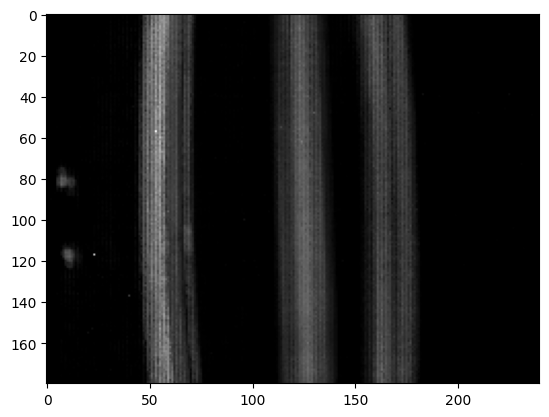

In [13]:
summed_image= visualize_mean_img_of_data_set(data_regular_reshaped)

In [8]:


dict_train= {
    'data': data_regular_reshaped,
    'layer_1_epochs' : 10,
    'layer_1_learning_rate' :0.1,
    'layer_1_lr_th' : .5,
    'layer_2_epochs' : 1,
    'layer_2_learning_rate' : 0.1,
    'layer_2_lr_th' : .5,
    'history_size' : 10
}


dict_construct = {
    'num_neurons_layer1_1' : 4,
    'num_neurons_layer2' : 3,
    'thersholds_bounds' : (.5, .2),
    'weights_bounds' : (.5, .1),
    'input_dim' : (180,240)
}

In [9]:
res_1 = construct_train(dict_construct, dict_train)

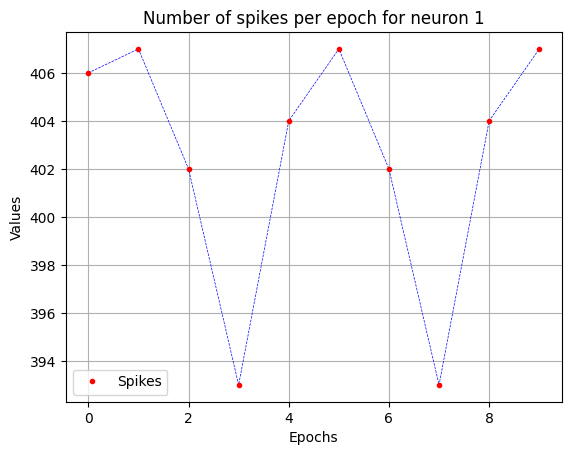

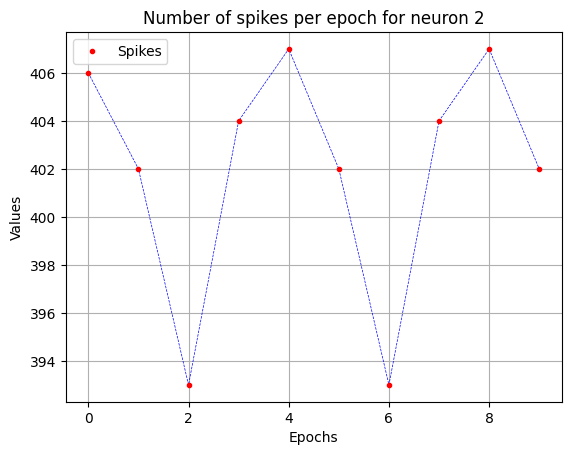

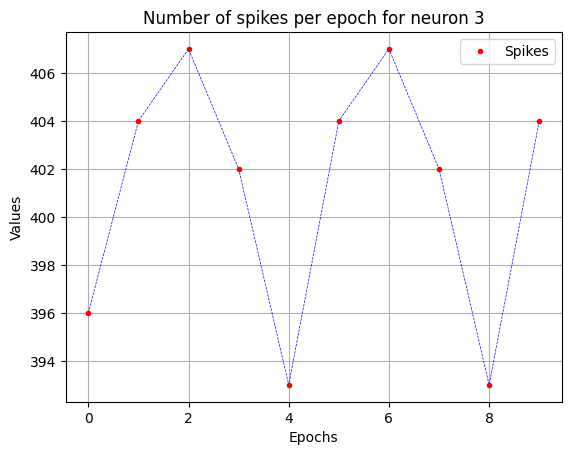

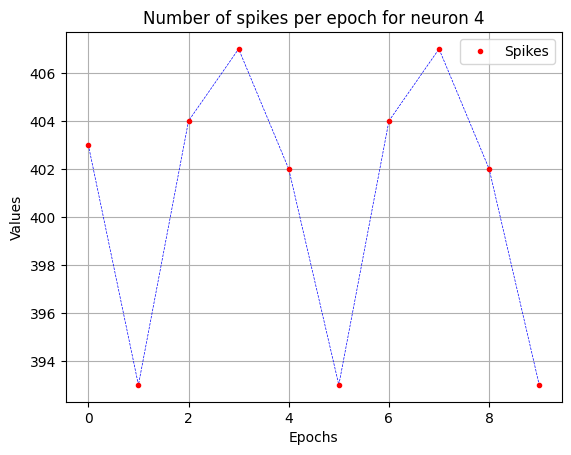

In [10]:
visualize_spikes(res_1[1])

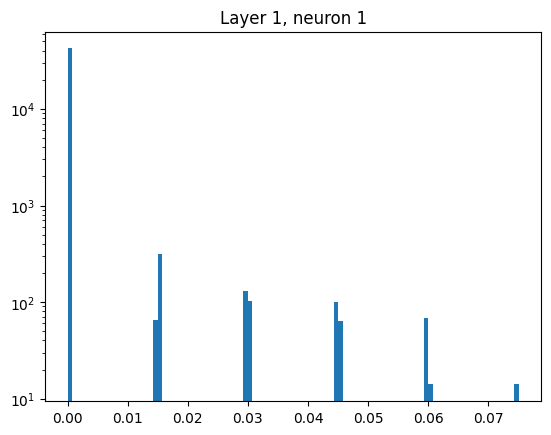

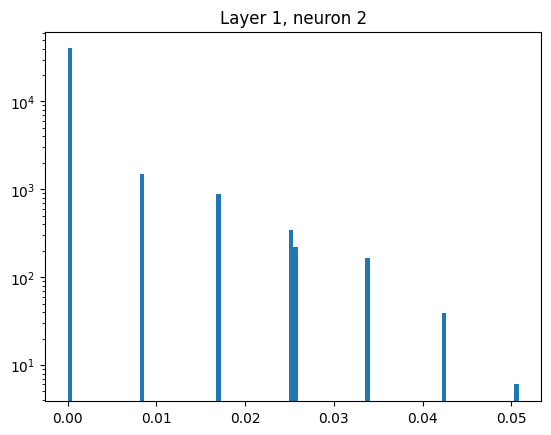

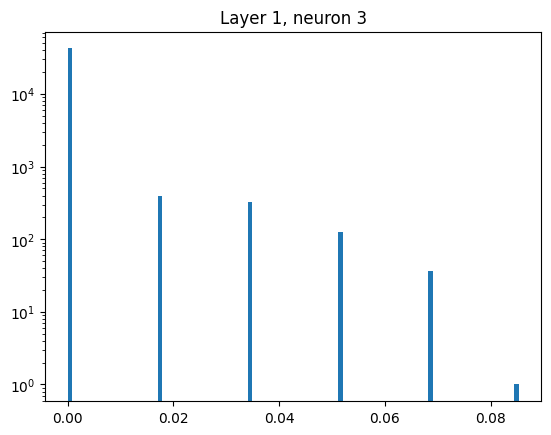

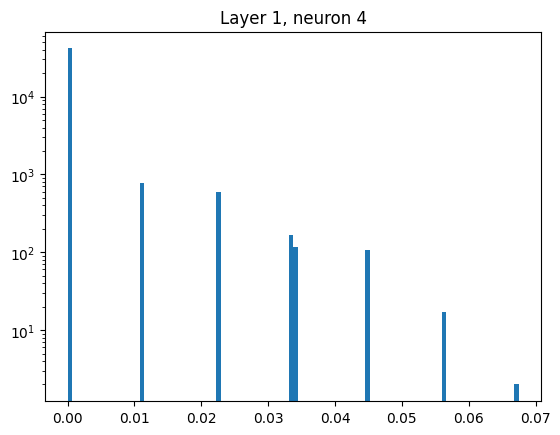

In [11]:
visualize_weights_distribution(res_1[4]._layer_1_weights)

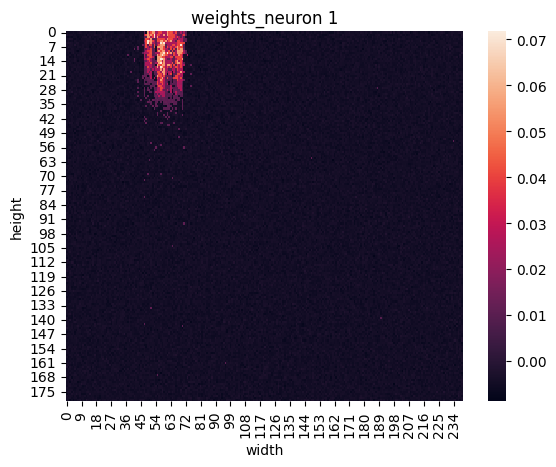

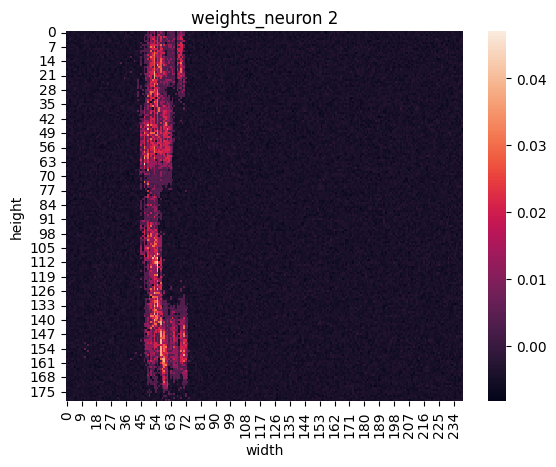

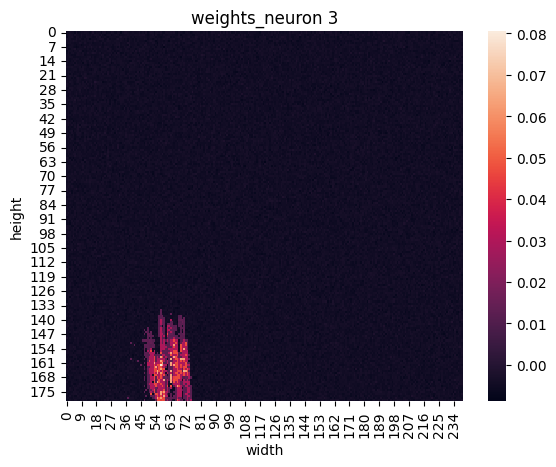

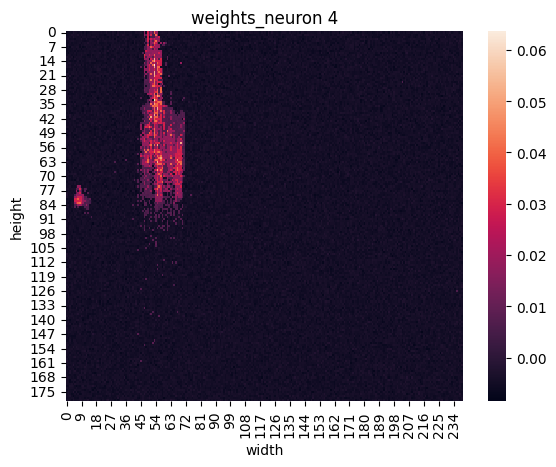

In [12]:
visualize_weights_pixels_correlation(res_1[4]._layer_1_weights, res_1[0])

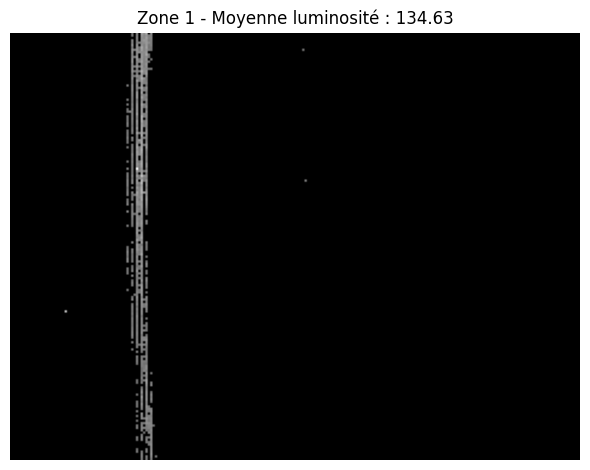

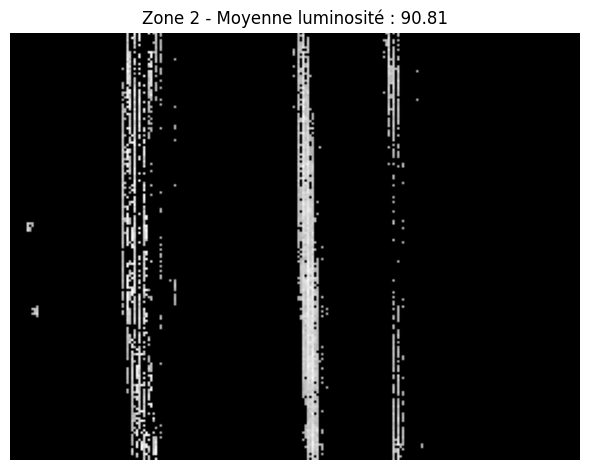

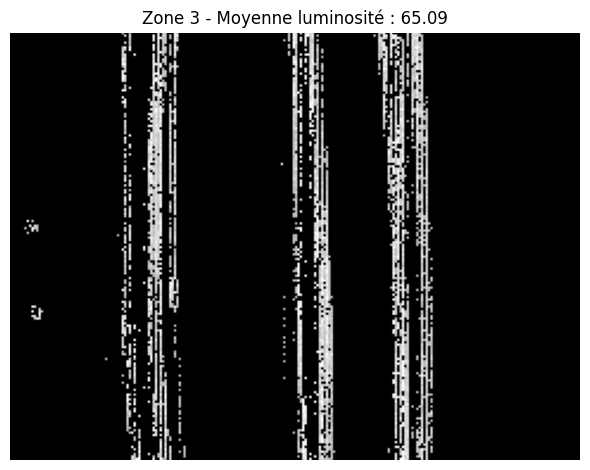

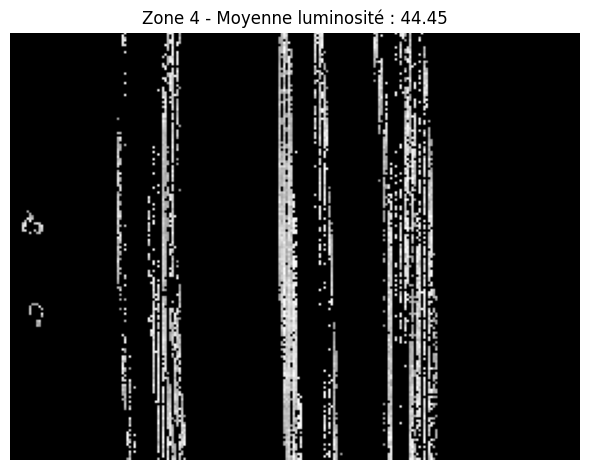

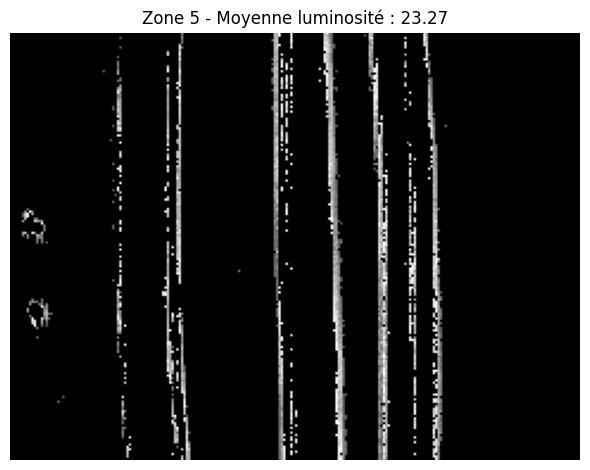

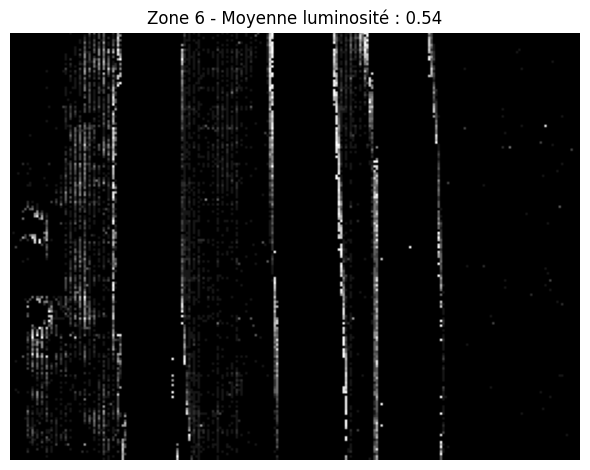

In [ ]:
adjusted = summed_image


h, w = adjusted.shape
X = adjusted.reshape(-1, 1)
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
labels = kmeans.labels_.reshape(h, w)


zone_infos = []
for label in np.unique(labels):
    mask = (labels == label)
    mean_intensity = adjusted[mask].mean()
    zone_infos.append({'label': label, 'mean': mean_intensity, 'mask': mask})


zone_infos.sort(key=lambda z: -z['mean'])


for i, zone in enumerate(zone_infos):
    mask = zone['mask']
    zone_img = np.zeros_like(adjusted)
    zone_img[mask] = adjusted[mask]

    plt.figure(figsize=(6, 5))
    plt.imshow(zone_img, cmap='gray')
    plt.title(f"Zone {i+1} - Moyenne luminosité : {zone['mean']:.2f}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


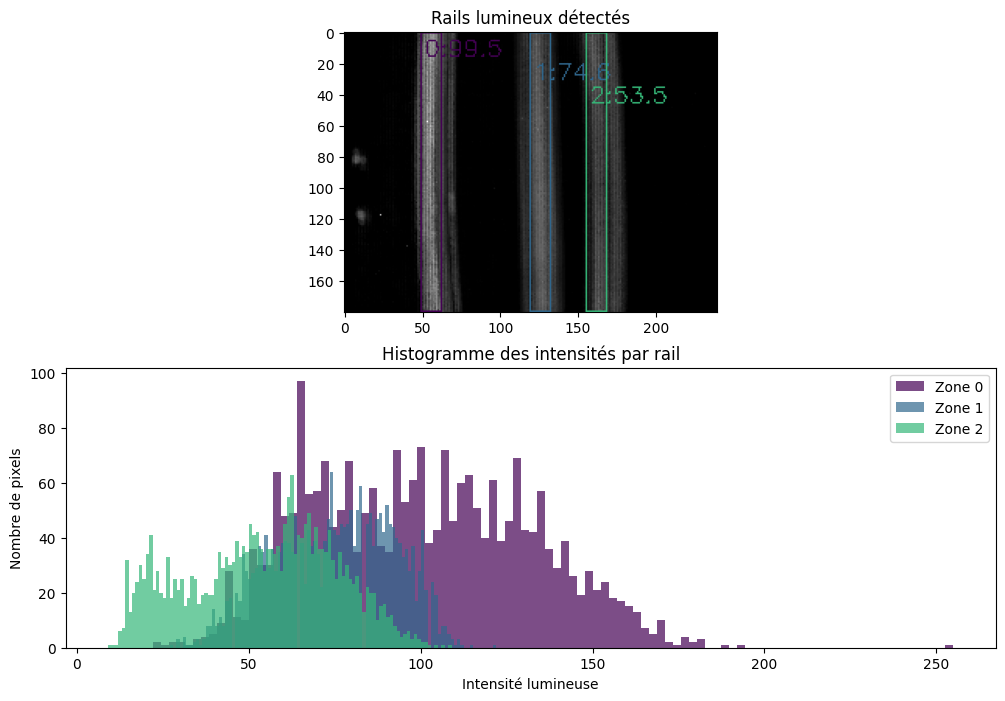

In [ ]:
adjusted = summed_image
column_intensity = adjusted.mean(axis=0)
profile = column_intensity 


peaks, _ = find_peaks(profile, height=np.percentile(profile, 90), distance=10)
rail_half_width = 6
rail_zones = []

for peak in peaks:
    x_start = max(0, peak - rail_half_width)
    x_end = min(adjusted.shape[1], peak + rail_half_width + 1)

    rail_zone = adjusted[:, x_start:x_end]
    mean_intensity = rail_zone.mean()
    

    rail_zones.append({
        'x_start': x_start,
        'x_end': x_end,
        'mean': mean_intensity,
        'values': rail_zone.flatten()
    })


rail_zones.sort(key=lambda z: -z['mean'])


colors = [cm.viridis(i /len(rail_zones)) for i in range(len(rail_zones))]


annotated = cv2.cvtColor(adjusted.astype(np.uint8), cv2.COLOR_GRAY2BGR)
for idx, rail in enumerate(rail_zones):
    x1, x2 = rail['x_start'], rail['x_end']
    
    color = tuple(int(c * 255) for c in colors[idx][:3][::-1])  
    cv2.rectangle(annotated, (x1, 0), (x2, adjusted.shape[0]-1), color, 1)
    label = f"{idx}:{rail['mean']:.1f}"
    cv2.putText(annotated, label, (x1+2, 15 + idx * 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)


fig, (ax_img, ax_hist) = plt.subplots(2, 1, figsize=(12, 8))
ax_img.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
ax_img.set_title("Rails lumineux détectés")



for idx, rail in enumerate(rail_zones):
    ax_hist.hist(rail['values'], bins=100, alpha=0.7, label=f'Zone {idx}', color=colors[idx])

ax_hist.set_title("Histogramme des intensités par rail")
ax_hist.set_xlabel("Intensité lumineuse")
ax_hist.set_ylabel("Nombre de pixels")
ax_hist.legend()




